# **Solar Irradiance Prediction using AI **

## **Dataset**
has following attributes

- Solar Irradiance (W/m<sup>2</sup>)
- Temperature (&deg;F)
- Barometric Pressure (Hg)
- Humidity (%)
- Wind Direction (&deg;)
- Wind Speed (mph)
- Sun Rise/Set Time

## **Aim**
 To accurately model solar irradiance from other meteorological parameters contained within the dataset.


## **Importing Required Libraries**

In [69]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
%matplotlib inline
import torch
import fastai

## **Importing The Dataset**

In [95]:
PATH = Path("./../data")

In [96]:
dataset = pd.read_csv(PATH/'SolarPrediction.csv')
dataset = dataset.sort_values(['UNIXTime'], ascending = [True])
dataset.head()

UNIXTime                  Data      Time  Radiation  Temperature  \
7416  1472724008  9/1/2016 12:00:00 AM  00:00:08       2.58           51   
7415  1472724310  9/1/2016 12:00:00 AM  00:05:10       2.83           51   
7414  1472725206  9/1/2016 12:00:00 AM  00:20:06       2.16           51   
7413  1472725505  9/1/2016 12:00:00 AM  00:25:05       2.21           51   
7412  1472725809  9/1/2016 12:00:00 AM  00:30:09       2.25           51   

      Pressure  Humidity  WindDirection(Degrees)  Speed TimeSunRise TimeSunSet  
7416     30.43       103                   77.27  11.25    06:07:00   18:38:00  
7415     30.43       103                  153.44   9.00    06:07:00   18:38:00  
7414     30.43       103                  142.04   7.87    06:07:00   18:38:00  
7413     30.43       103                  144.12  18.00    06:07:00   18:38:00  
7412     30.43       103                   67.42  11.25    06:07:00   18:38:00

## **Feature Engineering**

In [23]:
from datetime import datetime
from pytz import timezone
import pytz
hawaii= timezone('Pacific/Honolulu')
dataset.index =  pd.to_datetime(dataset['UNIXTime'], unit='s')
dataset.index = dataset.index.tz_localize(pytz.utc).tz_convert(hawaii)
dataset['MonthOfYear'] = dataset.index.strftime('%m').astype(int)
dataset['DayOfYear'] = dataset.index.strftime('%j').astype(int)
dataset['WeekOfYear'] = dataset.index.strftime('%U').astype(int)
dataset['TimeOfDay(h)'] = dataset.index.hour
dataset['TimeOfDay(m)'] = dataset.index.hour*60 + dataset.index.minute
dataset['TimeOfDay(s)'] = dataset.index.hour*60*60 + dataset.index.minute*60 + dataset.index.second
dataset['TimeSunRise'] = pd.to_datetime(dataset['TimeSunRise'], format='%H:%M:%S')
dataset['TimeSunSet'] = pd.to_datetime(dataset['TimeSunSet'], format='%H:%M:%S')
dataset['DayLength(s)'] = dataset['TimeSunSet'].dt.hour*60*60 \
                           + dataset['TimeSunSet'].dt.minute*60 \
                           + dataset['TimeSunSet'].dt.second \
                           - dataset['TimeSunRise'].dt.hour*60*60 \
                           - dataset['TimeSunRise'].dt.minute*60 \
                           - dataset['TimeSunRise'].dt.second
dataset.drop(['Data','Time','TimeSunRise','TimeSunSet'], inplace=True, axis=1)
dataset.head()

UNIXTime  Radiation  Temperature  Pressure  \
UNIXTime                                                                  
2016-09-01 00:00:08-10:00  1472724008       2.58           51     30.43   
2016-09-01 00:05:10-10:00  1472724310       2.83           51     30.43   
2016-09-01 00:20:06-10:00  1472725206       2.16           51     30.43   
2016-09-01 00:25:05-10:00  1472725505       2.21           51     30.43   
2016-09-01 00:30:09-10:00  1472725809       2.25           51     30.43   

                           Humidity  WindDirection(Degrees)  Speed  \
UNIXTime                                                             
2016-09-01 00:00:08-10:00       103                   77.27  11.25   
2016-09-01 00:05:10-10:00       103                  153.44   9.00   
2016-09-01 00:20:06-10:00       103                  142.04   7.87   
2016-09-01 00:25:05-10:00       103                  144.12  18.00   
2016-09-01 00:30:09-10:00       103                   67.42  11.25   

                           MonthOfYear  DayOfYear  WeekOfYear  TimeOfDay(h)  \
UNIXTime                                                                      
2016-09-01 00:00:08-10:00            9        245          35             0   
2016-09-01 00:05:10-10:00            9        245          35             0   
2016-09-01 00:20:06-10:00            9        245          35             0   
2016-09-01 00:25:05-10:00            9        245          35             0   
2016-09-01 00:30:09-10:00            9        245          35             0   

                           TimeOfDay(m)  TimeOfDay(s)  DayLength(s)  
UNIXTime                                                             
2016-09-01 00:00:08-10:00             0             8         45060  
2016-09-01 00:05:10-10:00             5           310         45060  
2016-09-01 00:20:06-10:00            20          1206         45060  
2016-09-01 00:25:05-10:00            25          1505         45060  
2016-09-01 00:30:09-10:00            30          1809         45060

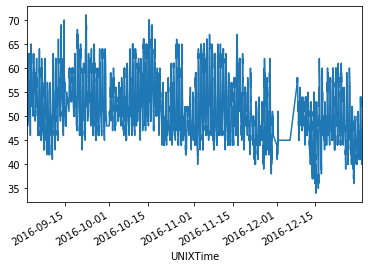

In [24]:
dataset['Temperature'].plot()

In [29]:
dataset['Temperature'] = dataset['Temperature'].apply(lambda x: (x-32)*5/9.0)

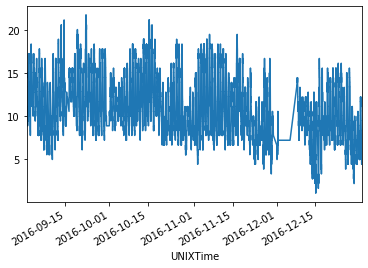

In [25]:
dataset['Temperature'].apply(lambda x: (x-32)*5/9.0).plot()

In [74]:
dataset['MonthOfYear']

UNIXTime
2016-09-01 00:00:08-10:00     9
2016-09-01 00:05:10-10:00     9
2016-09-01 00:20:06-10:00     9
2016-09-01 00:25:05-10:00     9
2016-09-01 00:30:09-10:00     9
                             ..
2016-12-31 23:35:02-10:00    12
2016-12-31 23:40:01-10:00    12
2016-12-31 23:45:04-10:00    12
2016-12-31 23:50:03-10:00    12
2016-12-31 23:55:01-10:00    12
Name: MonthOfYear, Length: 32686, dtype: int64

In [89]:
dataset.groupby(["MonthOfYear", "TimeOfDay(h)"]).agg({"Radiation":np.mean}).loc[12]

Radiation
TimeOfDay(h)            
0               1.230483
1               1.230982
2               1.230238
3               1.231220
4               1.229194
5               1.231458
6               2.291101
7              28.260744
8             211.472209
9             360.543910
10            456.808925
11            473.817536
12            526.824162
13            466.523764
14            369.472824
15            276.515884
16            151.599741
17             25.954080
18              1.287040
19              1.237184
20              1.235202
21              1.235446
22              1.232798
23              1.231131

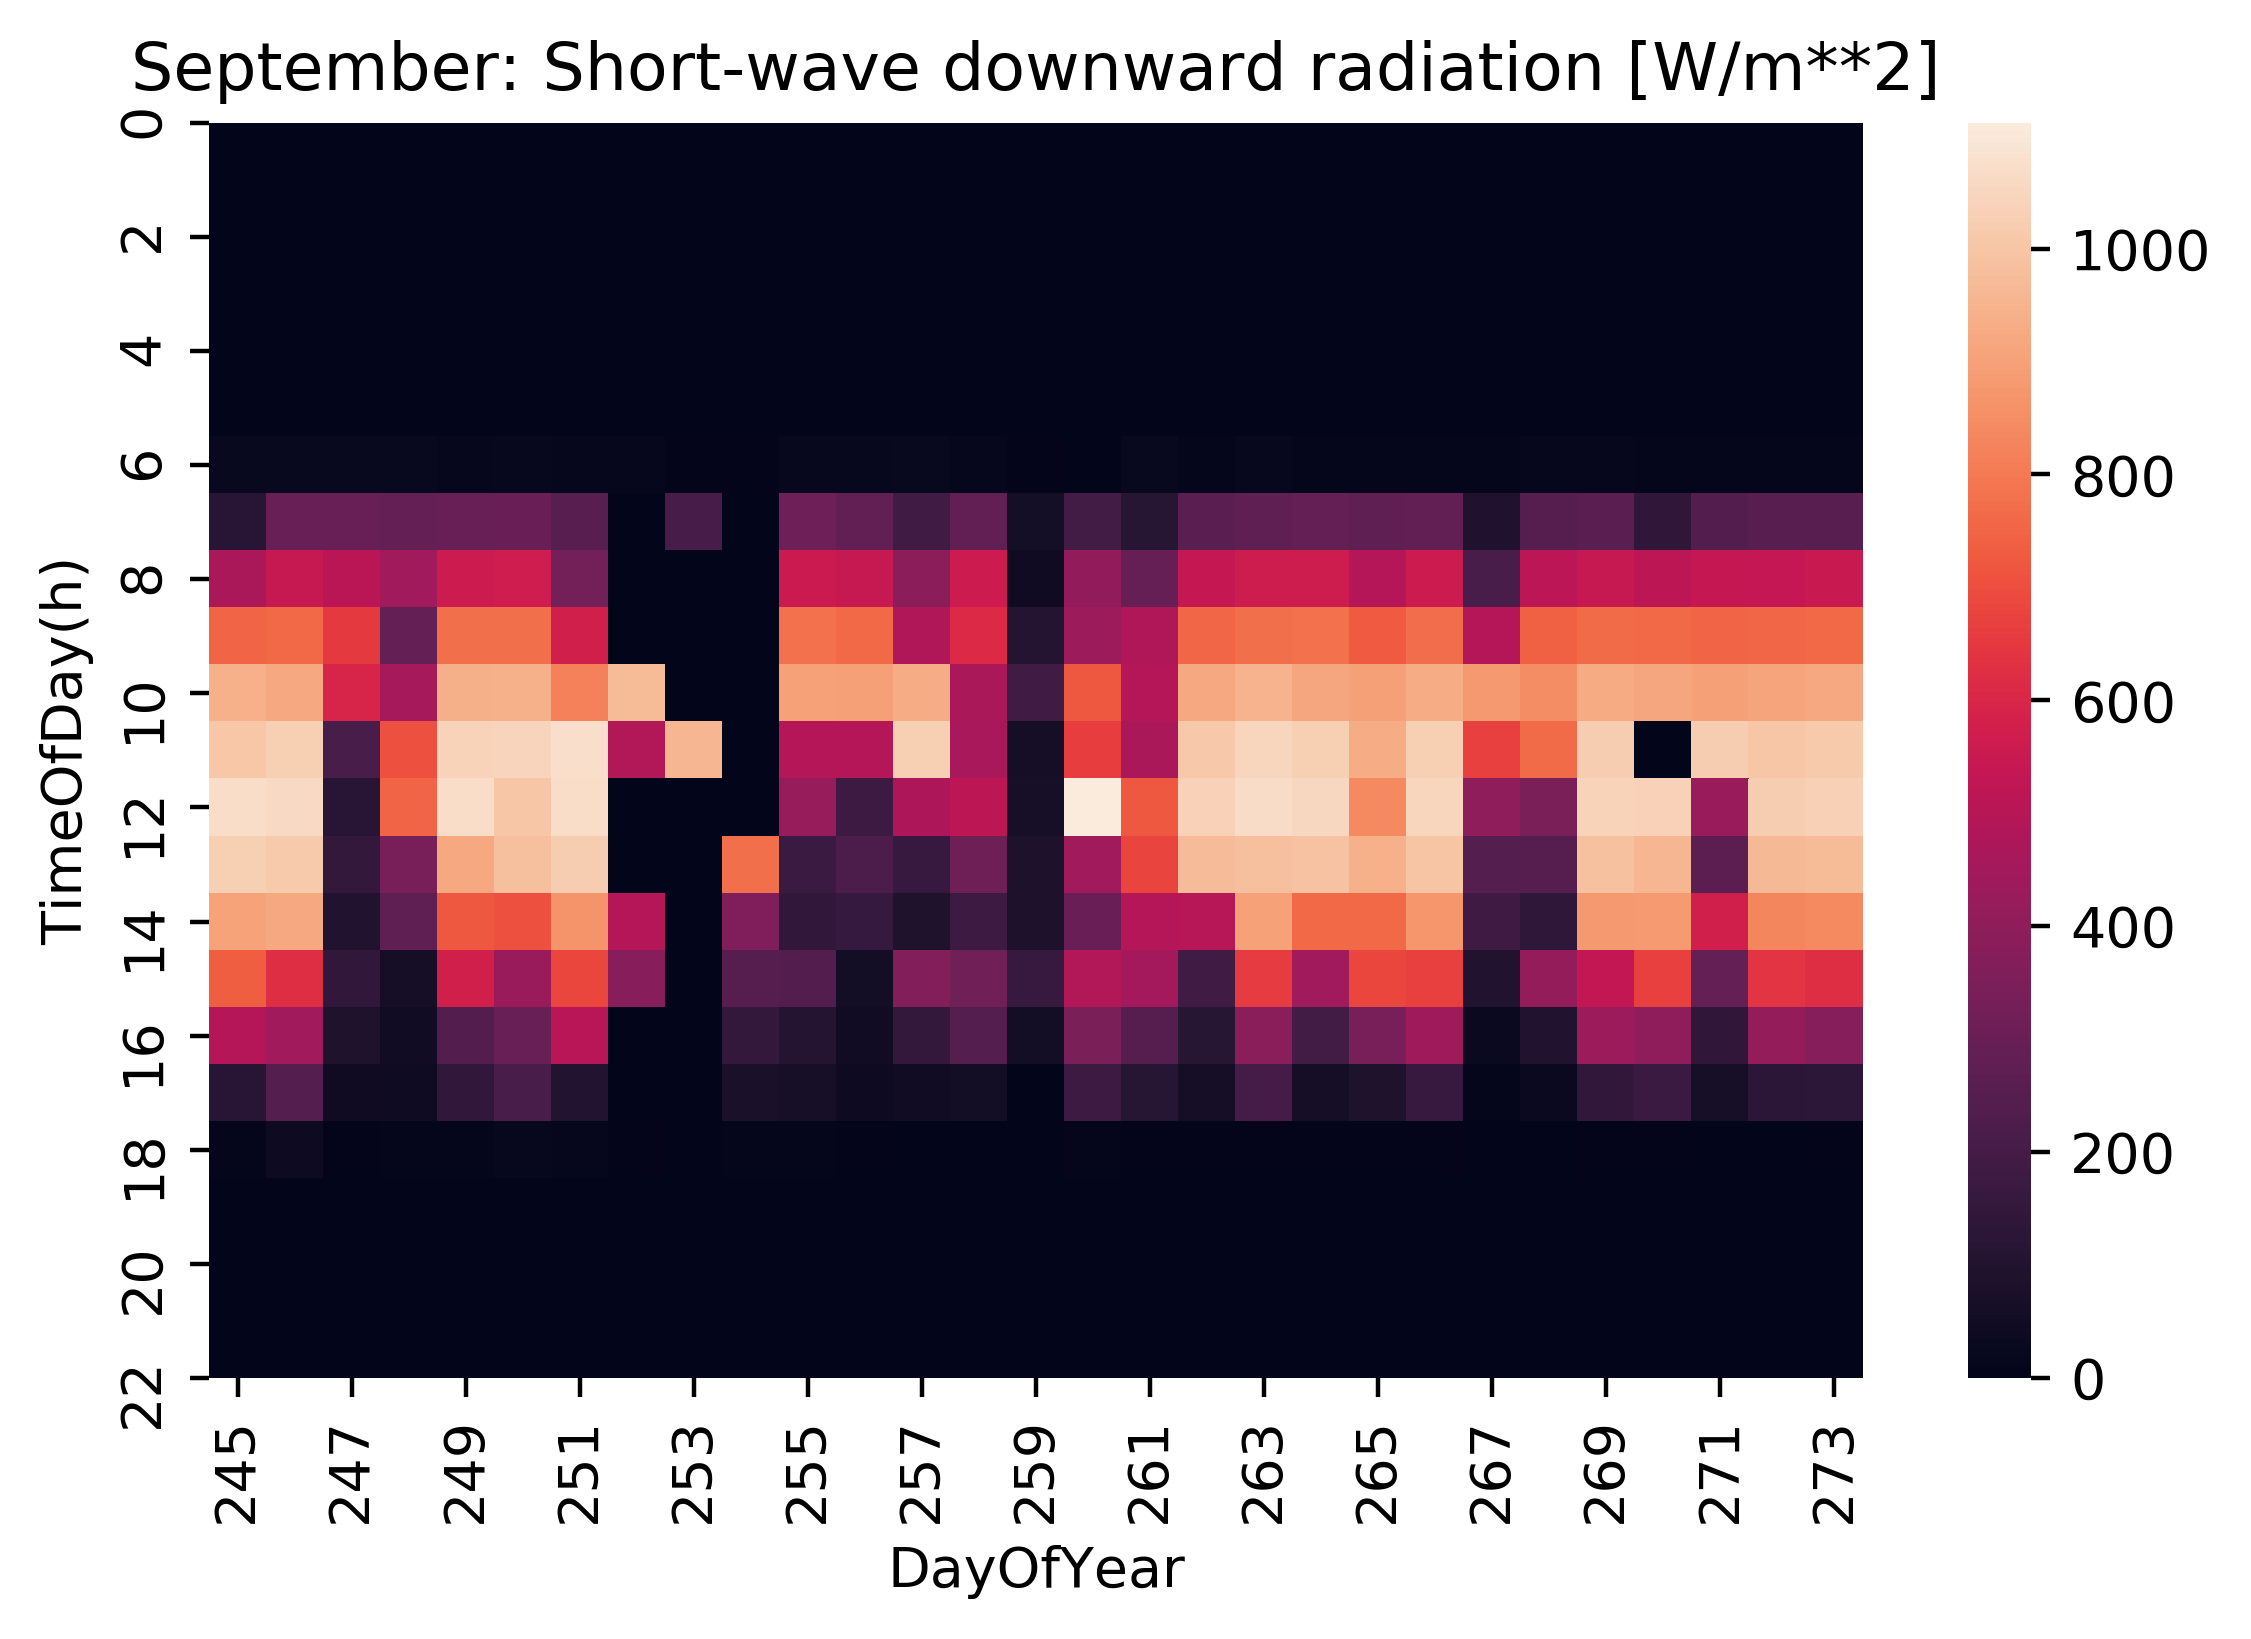

In [93]:
# July
piv = pd.pivot_table(dataset[(dataset['MonthOfYear'] == 9)], values="Radiation", index=[
                     "TimeOfDay(h)"], columns=["DayOfYear"], fill_value=0)
plt.figure(dpi=400)
ax = sns.heatmap(piv, square=True)
#plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)
plt.title('September: Short-wave downward radiation [W/m**2]')
plt.tight_layout()
plt.show()

In [30]:
dataset

UNIXTime  Radiation  Temperature  Pressure  \
UNIXTime                                                                  
2016-09-01 00:00:08-10:00  1472724008       2.58    10.555556     30.43   
2016-09-01 00:05:10-10:00  1472724310       2.83    10.555556     30.43   
2016-09-01 00:20:06-10:00  1472725206       2.16    10.555556     30.43   
2016-09-01 00:25:05-10:00  1472725505       2.21    10.555556     30.43   
2016-09-01 00:30:09-10:00  1472725809       2.25    10.555556     30.43   
...                               ...        ...          ...       ...   
2016-12-31 23:35:02-10:00  1483263302       1.22     5.000000     30.34   
2016-12-31 23:40:01-10:00  1483263601       1.21     5.000000     30.34   
2016-12-31 23:45:04-10:00  1483263904       1.21     5.555556     30.34   
2016-12-31 23:50:03-10:00  1483264203       1.19     5.000000     30.34   
2016-12-31 23:55:01-10:00  1483264501       1.21     5.000000     30.34   

                           Humidity  WindDirection(Degrees)  Speed  \
UNIXTime                                                             
2016-09-01 00:00:08-10:00       103                   77.27  11.25   
2016-09-01 00:05:10-10:00       103                  153.44   9.00   
2016-09-01 00:20:06-10:00       103                  142.04   7.87   
2016-09-01 00:25:05-10:00       103                  144.12  18.00   
2016-09-01 00:30:09-10:00       103                   67.42  11.25   
...                             ...                     ...    ...   
2016-12-31 23:35:02-10:00        83                  238.94   6.75   
2016-12-31 23:40:01-10:00        82                  236.79   5.62   
2016-12-31 23:45:04-10:00        81                  218.28   7.87   
2016-12-31 23:50:03-10:00        80                  215.23   7.87   
2016-12-31 23:55:01-10:00        81                  215.56   9.00   

                           MonthOfYear  DayOfYear  WeekOfYear  TimeOfDay(h)  \
UNIXTime                                                                      
2016-09-01 00:00:08-10:00            9        245          35             0   
2016-09-01 00:05:10-10:00            9        245          35             0   
2016-09-01 00:20:06-10:00            9        245          35             0   
2016-09-01 00:25:05-10:00            9        245          35             0   
2016-09-01 00:30:09-10:00            9        245          35             0   
...                                ...        ...         ...           ...   
2016-12-31 23:35:02-10:00           12        366          52            23   
2016-12-31 23:40:01-10:00           12        366          52            23   
2016-12-31 23:45:04-10:00           12        366          52            23   
2016-12-31 23:50:03-10:00           12        366          52            23   
2016-12-31 23:55:01-10:00           12        366          52            23   

                           TimeOfDay(m)  TimeOfDay(s)  DayLength(s)  
UNIXTime                                                             
2016-09-01 00:00:08-10:00             0             8         45060  
2016-09-01 00:05:10-10:00             5           310         45060  
2016-09-01 00:20:06-10:00            20          1206         45060  
2016-09-01 00:25:05-10:00            25          1505         45060  
2016-09-01 00:30:09-10:00            30          1809         45060  
...                                 ...           ...           ...  
2016-12-31 23:35:02-10:00          1415         84902         39420  
2016-12-31 23:40:01-10:00          1420         85201         39420  
2016-12-31 23:45:04-10:00          1425         85504         39420  
2016-12-31 23:50:03-10:00          1430         85803         39420  
2016-12-31 23:55:01-10:00          1435         86101         39420  

[32686 rows x 14 columns]

In [31]:
grouped_d

DayOfYear      UNIXTime   Radiation  Temperature   Pressure   Humidity  \
0          245  1.472768e+09  298.451600    54.556000  30.436640  78.968000   
1          246  1.472854e+09  333.471219    56.379928  30.446487  72.501792   
2          247  1.472940e+09  123.974574    55.507092  30.438546  94.599291   
3          248  1.473027e+09  153.584321    53.589286  30.454107  93.878571   
4          249  1.473113e+09  306.065125    53.199288  30.419680  79.943060   
..         ...           ...         ...          ...        ...        ...   
113        362  1.482876e+09  239.910556    49.888889  30.431181  31.687500   
114        363  1.482962e+09  174.910278    45.149306  30.384965  86.788194   
115        364  1.483049e+09  125.018049    43.571429  30.328397  89.271777   
116        365  1.483135e+09   88.367684    45.087719  30.312070  82.312281   
117        366  1.483221e+09  144.288542    46.250000  30.312604  83.302083   

     WindDirection(Degrees)     Speed  MonthOfYear  WeekOfYear  TimeOfDay(h)  \
0                112.564000  6.396560          9.0        35.0     11.756000   
1                115.392079  5.804086          9.0        35.0     11.734767   
2                192.678546  4.960248          9.0        35.0     11.570922   
3                126.336714  5.184571          9.0        36.0     11.657143   
4                209.169253  5.830676          9.0        36.0     11.708185   
..                      ...       ...          ...         ...           ...   
113              133.341458  8.692708         12.0        52.0     11.500000   
114              134.345000  7.181076         12.0        52.0     11.500000   
115              130.917596  4.677805         12.0        52.0     11.512195   
116              222.130947  4.592211         12.0        52.0     11.473684   
117              265.131424  7.431042         12.0        52.0     11.500000   

     TimeOfDay(m)  TimeOfDay(s)  DayLength(s)  
0      731.960000  43924.208000       45060.0  
1      731.630824  43903.218638       45000.0  
2      721.826241  43314.698582       44880.0  
3      726.857143  43617.060714       44820.0  
4      730.053381  43811.697509       44820.0  
..            ...           ...           ...  
113    717.538194  43097.680556       39360.0  
114    717.538194  43097.684028       39360.0  
115    718.181185  43110.428571       39420.0  
116    715.894737  42956.943860       39420.0  
117    717.500000  43052.399306       39420.0  

[118 rows x 14 columns]

## **Feature Visualisation**


<Figure size 3600x2400 with 0 Axes>

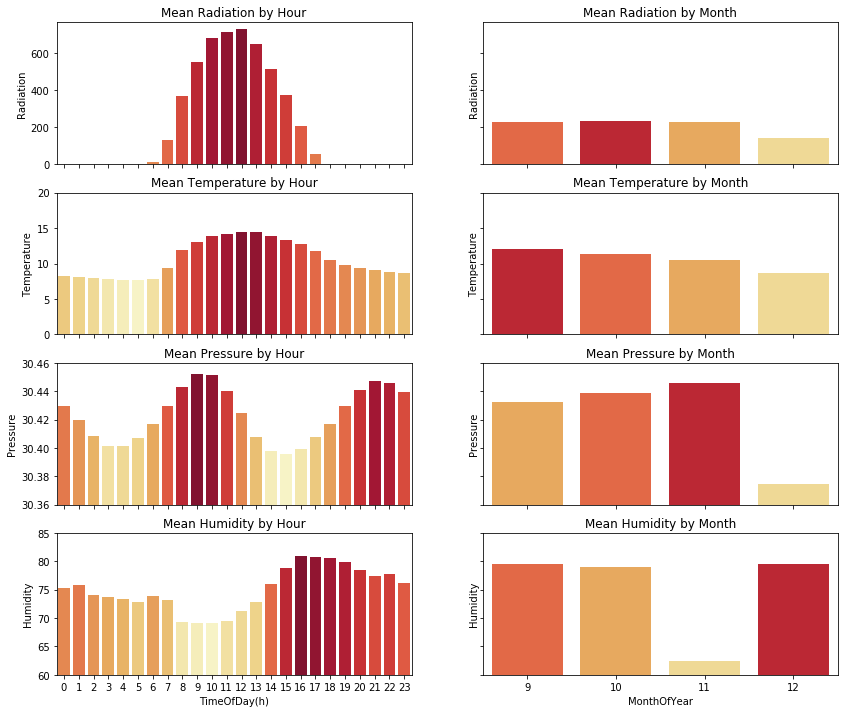

In [36]:
grouped_m=dataset.groupby('MonthOfYear').mean().reset_index()
grouped_w=dataset.groupby('WeekOfYear').mean().reset_index()
grouped_d=dataset.groupby('DayOfYear').mean().reset_index()
grouped_h=dataset.groupby('TimeOfDay(h)').mean().reset_index()
plt.figure(dpi=600)

f, ((ax1, ax2), (ax3, ax4), (ax5, ax6), (ax7, ax8)) = plt.subplots(4, 2, sharex='col', sharey='row', figsize=(14,12))
ax3.set_ylim(0,20)
ax5.set_ylim(30.36,30.46)
ax7.set_ylim(60,85)

ax1.set_title('Mean Radiation by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Radiation'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Radiation', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax1)
ax1.set_xlabel('')

ax2.set_title('Mean Radiation by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Radiation'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Radiation', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax2)
ax2.set_xlabel('')

ax3.set_title('Mean Temperature by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Temperature'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Temperature', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax3)
ax3.set_xlabel('')

ax4.set_title('Mean Temperature by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Temperature'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Temperature', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax4)
ax4.set_xlabel('')

ax5.set_title('Mean Pressure by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Pressure'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Pressure', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax5)
ax5.set_xlabel('')

ax6.set_title('Mean Pressure by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Pressure'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Pressure', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax6)
ax6.set_xlabel('')

ax7.set_title('Mean Humidity by Hour')
pal = sns.color_palette("YlOrRd_r", len(grouped_h))
rank = grouped_h['Humidity'].argsort().argsort() 
g = sns.barplot(x="TimeOfDay(h)", y='Humidity', data=grouped_h, palette=np.array(pal[::-1])[rank], ax=ax7)

ax8.set_title('Mean Humidity by Month')
pal = sns.color_palette("YlOrRd_r", len(grouped_m))
rank = grouped_m['Humidity'].argsort().argsort() 
g = sns.barplot(x="MonthOfYear", y='Humidity', data=grouped_m, palette=np.array(pal[::-1])[rank], ax=ax8)

plt.show()

## **Pearson Correlation**

<Figure size 2400x1600 with 0 Axes>

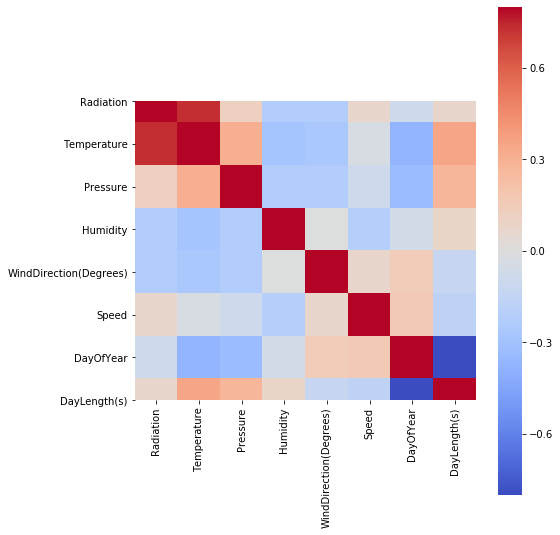

In [47]:
corrmat = dataset.drop(['TimeOfDay(h)', 'TimeOfDay(m)', 'TimeOfDay(s)', 'UNIXTime', 'MonthOfYear', 'WeekOfYear'], inplace=False, axis=1)
corrmat = corrmat.corr()
plt.figure(dpi=400)
f, ax = plt.subplots(figsize=(8,8))
sns.heatmap(corrmat, vmin=-.8, vmax=.8, square=True, cmap = 'coolwarm')
#plt.show()
plt.tight_layout()
plt.savefig("./corr.jpeg", dpi=600)

The correlation heatmap confirms the relationships suggested in the previous sections. It also suggests that the day of year will have a significantly weaker influence on solar irradiance compared to temperature.

## **Separating the Independent and Dependent Variables**

In [48]:
X = dataset[['Temperature', 'Pressure', 'Humidity', 'WindDirection(Degrees)', 'Speed', 'DayOfYear', 'TimeOfDay(s)']]
y = dataset['Radiation']

## **Splitting the Dataset**
The dataset was subsequently split into a training and test set, with an 80%, 20% split respectively.

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

## **Feature Selection**

In [50]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
regressor = RandomForestRegressor(n_estimators = 100)
regressor.fit(X_train, y_train)
feature_importances = regressor.feature_importances_

X_train_opt = X_train.copy()
removed_columns = pd.DataFrame()
models = []
r2s_opt = []

for i in range(0,5):
    least_important = np.argmin(feature_importances)
    removed_columns = removed_columns.append(X_train_opt.pop(X_train_opt.columns[least_important]))
    regressor.fit(X_train_opt, y_train)
    feature_importances = regressor.feature_importances_
    accuracies = cross_val_score(estimator = regressor,
                                 X = X_train_opt,
                                 y = y_train, cv = 5,
                                 scoring = 'r2')
    r2s_opt = np.append(r2s_opt, accuracies.mean())
    models = np.append(models, ", ".join(list(X_train_opt)))
    
feature_selection = pd.DataFrame({'Features':models,'r2 Score':r2s_opt})
feature_selection.head()

Features  r2 Score
0  Temperature, Pressure, Humidity, WindDirection...  0.932420
1  Temperature, Humidity, WindDirection(Degrees),...  0.931446
2     Temperature, Humidity, DayOfYear, TimeOfDay(s)  0.934095
3               Temperature, DayOfYear, TimeOfDay(s)  0.932596
4                          Temperature, TimeOfDay(s)  0.800115

From the dataframe output, it can be seen that model performance stays relatively constant until 'DayOfYear' is removed, leaving 'Temperature' and 'TimeOfDay(s)' as the only features. Without performing any parameter tuning it appears that the random forest regressor, fit to 'Temperature', 'TimeOfDay(s)' and 'DayOfYear' is able to acheive a r<sup>2</sup> score as high as 0.94.

## **Fitting the Regressor to the Key Features**
Given the result of the previous section the random forest regressor is trained using 'Temperature', 'TimeOfDay(s)' and 'DayOfYear'.

In [51]:
X_train_best = X_train[['Temperature', 'DayOfYear', 'TimeOfDay(s)']]
X_test_best = X_test[['Temperature', 'DayOfYear', 'TimeOfDay(s)']]
regressor.fit(X_train_best, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=100,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

## **Cross Validation**
Cross validation, with a greater number of folds, again shows an r<sup>2</sup> score of 0.93.

In [52]:
accuracies = cross_val_score(estimator = regressor, X = X_train_best,y = y_train, cv = 10, scoring = 'r2')
accuracy = accuracies.mean()
print('r2 = {}'.format(accuracy))

r2 = 0.934204028378003


## **Predicting the Test Set**
The trained regressor is the used to predict and test set data, which was not involved in the training process. Explained variance, mean squared error and r<sup>2</sup> scores were output to evaluate the accuracy of the models predictions.

In [53]:
from sklearn.metrics import explained_variance_score, mean_squared_error, r2_score
y_pred = regressor.predict(X_test_best)
explained_variance_score = explained_variance_score(y_test, y_pred)
mean_squared_error = mean_squared_error(y_test, y_pred)
r_squared = r2_score(y_test, y_pred)
print('explained variance = {}'.format(explained_variance_score))
print('mse = {}'.format(mean_squared_error))
print('r2 = {}'.format(r_squared))

explained variance = 0.9394851481146151
mse = 6243.295062075128
r2 = 0.9394325370115125


The performance acheived when estimating the test set is very close to that found from cross validation, implying that the model is not overfit.

## **Visualising the Model**
In order to visualise the model, predictions were made for the entire dataset and an interactive plot created using the 'bokeh' library.

In [68]:
# Predicting for whole dataset
dataset['y_pred'] = regressor.predict(dataset[['Temperature', 'DayOfYear', 'TimeOfDay(s)']])

# Create Interactive Plot Using Bokeh
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Range1d
output_notebook() 

p = figure(plot_width=1*800, 
           plot_height=1*400,
           title="Solar Irradiance Predictions",
           x_axis_label='Date and Time',
           y_axis_label='Solar Irradiance',
           x_axis_type="datetime")
p.xaxis.axis_label_text_font_size = "20pt"
p.yaxis.axis_label_text_font_size = "20pt"
p.xaxis.major_label_text_font_size = "14pt"
p.yaxis.major_label_text_font_size = "14pt"
p.title.text_font_size = '15pt'
p.x_range = Range1d(dataset.index[0], dataset.index[600])
p.y_range = Range1d(-100, 1800, bounds=(-100, 1800))
p.line(dataset.index, dataset['Radiation'], legend='Observed Solar Irradiance', line_width=1)
p.line(dataset.index, dataset['y_pred'], legend='Predicted Solar Irradiance', line_width=1, line_color="red")

show(p, notebook_handle = True)

Loading BokehJS ...

From the plot it can be see that the predictions closely match the observations.

## **Conclusion**
The variables most relevant to the prediction of solar irradiance were found to be temperature, time of day, and day of year. Training a random forest regressor with these three variables (with units of farenheit, seconds, and days respectively) produced a model that acheived a mean r<sup>2</sup> score of 0.93 when cross validation was performed. When comparing predictions to a test set, again, an r<sup>2</sup> score of approximately 0.93 was obtained.

It may be possible to tune the random forest regressor to obtain an even higher r<sup>2</sup> score but realisitically the model produced is unlikely to be any better at solar irradiance prediction, it will just fit the observations of one particular year extremely well. To create a more useful model, the regressor should be trained on data recorded over several years.

Similarly other types of regressors may perform better than the random forest regressor when trained on the same set of features, upon achieving such a high r<sup>2</sup> score with the random forest regressor little, thought was put into model selection.
